In [18]:
import os
import urllib # 웹에서 데이터를 다운로드할 때 사용
import cv2 # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation #시맨틱 세그맨테이션
from matplotlib import pyplot as plt

print('슝=3')

슝=3


(716, 1110, 3)


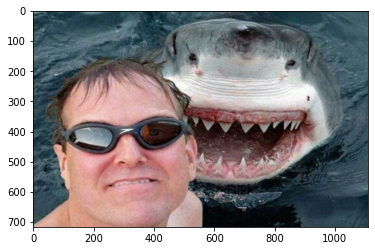

In [19]:
#이미지 경로 지정
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.png'  #
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
#먼저 PixelLib에서 제공해 주는 모델을 다운로드

# 저장할 파일 이름을 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f813b8a8130>)

In [21]:
# 그다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [22]:
#모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [23]:
# PASCAL VOC 데이터의 라벨 종류 
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)


21

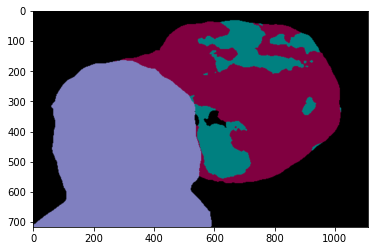

In [24]:
#세그멘테이션 된 결과가 각각 다른 색상으로 담겨 있음
plt.imshow(output)
plt.show()

In [25]:
# 클래스 아이디와 마스크가 있음.
segvalues

{'class_ids': array([ 0,  3, 12, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [26]:
# class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있음
#상어를 개와 새로 인식하고 있음
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bird
dog
person


In [27]:
# 물체마다 output에 어떤 색상으로 나타나 있는지 알아보기

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [28]:
# 사람을 나타내는 색상은 뭔지 알아보기

colormap[15]

array([192, 128, 128])

In [29]:
# 주의점: output 이미지는 bgr 순서로 채널 배치가 되어 있음. 하지만 colormap은 rgb 순서임

seg_color = (128,128,192)

(716, 1110)


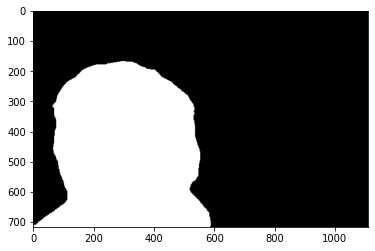

In [30]:
#seg_color로만 이루어진 마스크 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됨
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()
#3채널 가졌던 원본과 다르게 채널 정보가 사라짐

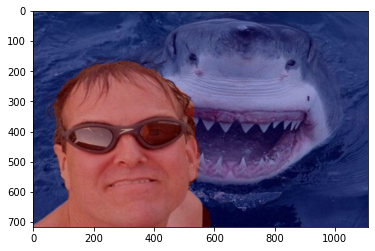

In [31]:
# 원래 이미지와 겹쳐서 보기, 세그멘테이션이 잘 되었는지 알아보기 쉬움.

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔주기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

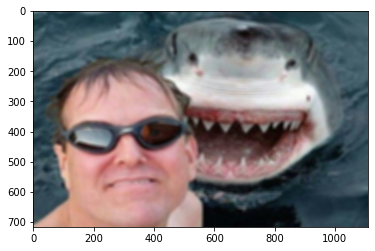

In [32]:
#배경 흐릐게 만들기, blur() 사용

# (13,13)은 blurring kernel size를 의미
# 다양하게 바꿔보기
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

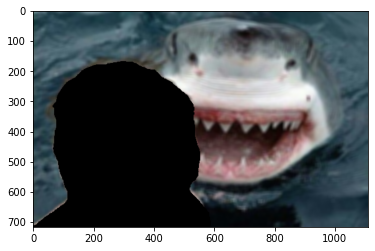

In [33]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
#bitwise_not 함수를 이용하면 이미지가 반전
#원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0
#반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻음
#0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됨
#결국 사람이 사라지게 됨


img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

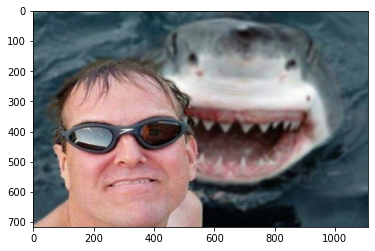

In [34]:
#블러 처리된 배경 영상과 사람 영상을 합치기

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()